<div id="colab_button">
  <h1>Quick tour</h1>
  <a target="_blank" href="https://colab.research.google.com/github/mithril-security/blindai-preview/blob/main/docs/docs/getting-started/quick-tour.ipynb"> 
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</div>
______________________________

In this notebook, we will explore how BlindAI can be used to deploy AI models in a privacy-respecting manner. BlindAI is an AI deployment solution which offers strong privacy guarantees by processing user data in a SGX secure enclave.

To let you discover BlindAI without having to install anything locally, we made [a Google Colab](https://colab.research.google.com/github/mithril-security/blindai-preview/blob/main/docs/docs/getting-started/quick-tour.ipynb) where you can directly follow this introduction tutorial. However, everything has been packaged and explained for you to be able to run this on your machine, if you wish to.  

> If you're still wondering why you should use BlindAI, you can go check [our introduction](https://blindai-preview.mithrilsecurity.io/en/latest/docs/getting-started/why-blindai/) on that topic. We'll focus on a hands-on demo in this tutorial.

#### The scenario: predicting Covid-19 with chest X-rays

We will begin by taking the perspective of an AI company that has developed a model and wants to deploy it. Then, we will step into the shoes of a data owner with a sensitive dataset they want to run the model on. This will allow us to take you through the workflow of BlindAI and its main features.

To make things more interesting, we will use a realistic but fictional example: predicting Covid-19 in patient chest X-ray images with Covid-NET. 

PixelHealth, an AI startup, has developed a neural network that can identify if a patient is affected by Covid-19 from their chest X-ray. 
The respiratory medicine department of the Sacred Heart Hospital is interested in using the PixelHealth service to improve patient care. 

The hospital can't afford the cost in time and money of an on-premise deployement on the hospital infrastructure, and the startup doesn't have the ressources to go through an independant security audit. Usually, this is where the collaboration ends because patient data is too sensitive to take any risk. But here, they decide to use BlindAI, which allows PixelHealth to deploy its model with the technical guarantees that patient data stays confidential. Using BlindAI, the hospital can benefit from AI assistance in diagnosis, and the AI company can retain its customer.

Let's get started. We will first need to download all the required dependencies for this notebook.

## Pre Requisites
_______________________________________

### Installing required dependencies

Unless you're are running this notebook [on Google Colab](https://colab.research.google.com/github/mithril-security/blindai-preview/blob/main/docs/docs/getting-started/quick-tour.ipynb), you'll need to have installed [`Python`](https://www.python.org/downloads/) (3.8 or greater), [`wget`](https://pypi.org/project/wget/) and [`pip`](https://pypi.org/project/pip/) 

Then, you'll need to install the BlindAI-preview package.

In [ ]:
# install blindai-preview package
!pip install blindai-preview

We will also need to install some additional dependencies for this notebook:

- [`numpy`](https://numpy.org/): for image pre-processing of our input data
- [`opencv-python`](https://pypi.org/project/opencv-python/): for image-preprocessing of our input data
- [`matplotlib`](https://matplotlib.org/): so that we can view our input image data.


In [ ]:
# install all other required packages
!pip install numpy opencv-python matplotlib

### Downloading the model

We will download the Covid-NET model that has already been trained to predict Covid-19 diagnosis based on images of chest x-rays.

You can download the file in ONNX format by running the following code block. The file will be saved as _"Covid-Net-CXR-2.onnx"_ in your current directory. 

In [ ]:
# package to import files from google drive
!pip install gdown

# Download the Covid-NET model in ONNX format
!gdown 1Rzl_XpV_kBw-lzu_5xYpc8briFd7fjvc

> Note that models must be uploaded as ONNX files. If you have a model that does not use the ONNX format, you will need to convert the file to ONNX format first.

## Uploading the model: the AI company's role
_____________________________________________

Now that we've got everything set up to be able to run this demo on both sides, let's start with the startup, PixelHealth's, point of view. 

We want to offer our service to a client that has a sensitive dataset. We decide to use BlindAI so that we can offer the privacy guarantees required by the client while protecting our model's IP.


### Launching the BlindAI server

Before we can upload our model to the server, we will need to launch an instance of BlindAI's server. 

For the purposes of this tutorial, we will use the `blindai_preview.testing` server which has been designed for testing purposes only.

In [1]:
# import testing submodule
import blindai_preview.testing

# start the server
srv = blindai_preview.testing.start_mock_server()

BlindAI mock server (version 0.0.6) already installed
BlindAI server is running at : 0.0.0.0:9923 and 0.0.0.0:9924


>Note that the blindai-preview testing module launches the server in simulation mode. As a result, it doesn't provide hardware protection and **must not be used in production**. We created this option to enable users to quickly and easily test BlindAI without needing to run the server on a machine with Intel SGX hardware. To learn more about how to run the server with hardware protections on, see [our documentation](https://blindai-preview.mithrilsecurity.io/en/latest/).

### Uploading the model

The server is up and running, so we will connect to the server using BlindAI's `connect()` function.

Since we are using a server in `simulation` mode, we need to set the `simulation_mode` parameter to `True` on the client side also. This is needed because the client will refuse to connect to an unsecure server otherwise.  

The `connect` method returns a `BlindAiConnection` object, which represents an active connection to a BlindAi server. This object gives us access to the methods needed to upload, run and delete models in BlindAI.

>Note, we also set the `hazmat_http_on_unattested_port` option to `True`. By default, the `blindai_preview` package requires a HTTPS connection for communications between the client and server on the unattested port 9923. But for testing purposes we opt out of this requirement and connect without a secure connection. This should not be done in production, please refer to our documentation to set up a production server.

In [2]:
# import blindai_preview
import blindai_preview 

# AI company connects
client_1 = blindai_preview.connect(addr="localhost", simulation_mode=True, hazmat_http_on_untrusted_port=True)

/workspaces/blindai-preview/client/blindai_preview/client.py:506: SimulationModeWarning: BlindAI is running in simulation mode. This mode is provided solely for testing purposes. It does not provide any security since there is no SGX enclave. The simulation mode MUST NOT be used in production.
  warnings.warn(


> For the purposes of this demo, we are running the server on localhost using the default ports, but note that the host and ports are modifiable parameters in the `connect()` function.

Now that we are connected to the server, we can go ahead and upload the model using the client `upload_model()` method. We'll need to specify the ONNX model's file name via the `model` parameter.

`upload_model()` returns an instance of the `UploadResponse` class to us. It has one attribute: a `model_id` string. This `model_id` is used to identify the model and will be used when running or deleting the model.

In [3]:
# AI company uploads model to server
response = client_1.upload_model(model="./COVID-Net-CXR-2.onnx")
MODEL_ID = response.model_id
print(MODEL_ID)

8afcdab8-209e-4b93-9403-f3ea2dc0c3ae


The model is now uploaded and we have a `model_id` we can share with our client. 

We, PixelHealth, can now close our connection to the server using the `close()` method.

In [4]:
# disconnect from sever
client_1.close()

Let's switch into the other role: the client who is going to upload their sensitive data and run the AI model on it.

## Preparing input features and running the model: the Data Owner's role
_______________________________________________

We are now the respiratory departement of Sacred Heart Hospital. We want to get help diagnosing our patients with Covid-19. This means we'll have to feed our confidential data to PixelHealth's Covid-NET model, but we need hard garantees that patients' private information can't be accessed by a third party or tampered with. We agreed to use BlindAI's with the startup.

We'll need to connect the client to the server in order to run PixelHealth's Covid-NET model on our data.

### Connection

Like the startup, we will connect to the server using the `connect()` function. 

In a real-life scenario we would put in the host address and ports specified to us by PixelHealth. For the purposes of this tutorial, we will continue to use `localhost`, default ports and set `simulation` mode to `True`.


In [6]:
# Data owner connects
client_2 = blindai_preview.connect(addr="localhost", simulation_mode=True, hazmat_http_on_untrusted_port=True)

/workspaces/blindai-preview/client/blindai_preview/client.py:506: SimulationModeWarning: BlindAI is running in simulation mode. This mode is provided solely for testing purposes. It does not provide any security since there is no SGX enclave. The simulation mode MUST NOT be used in production.
  warnings.warn(


## Data pre-processing

In a real-life scenario, we would already have our data locally, but for the purposes of this demo, we need to download some images that we run the Covid-NET model on.

Let's download two X-ray images from **11fenil11**'s open-source [GitHub repository](https://github.com/11fenil11/Covid19-Detection-Using-Chest-X-Ray):

* One where the patient has Covid, which we will save as `positive.jpeg`.
* One where the patient does not have Covid, which we will save as `negative.jpeg`.

In [9]:
!wget --quiet https://raw.githubusercontent.com/11fenil11/Covid19-Detection-Using-Chest-X-Ray/master/uploads/POSI02.jpeg -O positive.jpeg
!wget --quiet https://raw.githubusercontent.com/11fenil11/Covid19-Detection-Using-Chest-X-Ray/master/uploads/NORMAL2-IM-0730-0001.jpeg -O negative.jpeg

#### Compatibility requirements

Once the data is downloaded, we need to follow the pre-processing guidelines provided by the Covid-NET model provider to make sure they are compatible.

First of all, we copy and paste the following `crop_top()`, `central_crop()` and `process_image_file()` functions provided by [the Covid-NET GitHub repo](https://github.com/lindawangg/COVID-Net). This will crop our images to the dimensions expected by the model.

In [10]:
# import OpenCV for image processing
import cv2

# pre-processing functions provided by Covid-NET
def crop_top(img, percent=0.15):
    offset = int(img.shape[0] * percent)
    return img[offset:]

def central_crop(img):
    size = min(img.shape[0], img.shape[1])
    offset_h = int((img.shape[0] - size) / 2)
    offset_w = int((img.shape[1] - size) / 2)
    return img[offset_h:offset_h + size, offset_w:offset_w + size]

def process_image_file(filepath, size, top_percent=0.08, crop=True):
    img = cv2.imread(filepath)
    img = crop_top(img, percent=top_percent)
    if crop:
        img = central_crop(img)
    img = cv2.resize(img, (size, size))
    return img

Now that we have the required pre-processing functions, we can call `process_image_file()` for both of our two test images using the defaul image size of 480. We save the resulting images in `positive` and `negative` objects respectively.

In [11]:
# saving the 480px images in their respective objects
positive = process_image_file("./positive.jpeg", size=480)
negative = process_image_file("./negative.jpeg", size=480)

#### Normalizing the data

We will now **normalize** the data. It is not compulsory, but it is preferred for neural networks models. 

We will convert our pixel values from integer values to 32 bit floats. We'll also scale them to values between 0.0 and 1.0 by dividing them by 255 (the maximum pixel value).

In [12]:
import numpy as np

# normalizing the data
positive = positive.astype("float32") / 255.0
negative = negative.astype("float32") / 255.0

#### Adding a dimension to images

There is one last step to do to prepare the images for the model. The model requires images to be send with an additional dimension, so we will add a dimension to each image using the `np.newaxis()` method.

In [13]:
# add dimension to images
positive = positive[np.newaxis,:,:,:]
negative = negative[np.newaxis,:,:,:]

We can view these images using **matplolib.pyplot**'s [`imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function.

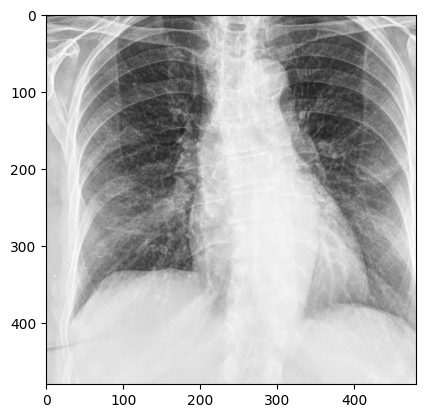

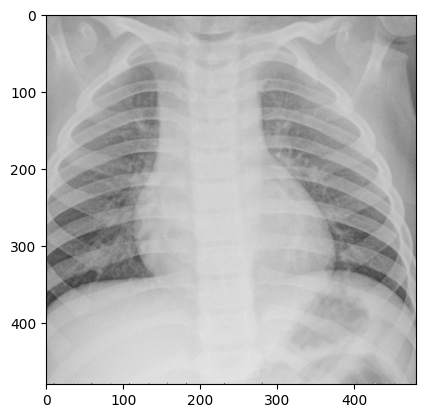

In [14]:
import matplotlib.pyplot as plt

# print out positive image
plt.imshow(positive[0])
plt.show()

# print out negative image
plt.imshow(negative[0])
plt.show()

### Running the model

On to the last step: using BlindAI to run the Covid-NET model on our images!

To do this, we will use the `BlindAiConnection` method `run_model()`. We'll provide with the `model_id` PixelHealth gave us and our two images. 

In [15]:
# Data owner runs model by providing model_id and uploading images
pos_ret = client_2.run_model(MODEL_ID, positive)
neg_ret = client_2.run_model(MODEL_ID, negative)

`run_model()` returns a `RunModelResponse` object which contains an `ouput` list.

Since this model accepts just one image at a time, the results for each image will be in the `0` index of output. Then, by using the `as_flat()` method, we convert the predictions calculated by the server to a flat python list. 

Finally, we index into `[0][1]` of the list to get our probability of Covid for each image as specified in the model guidelines.

In [16]:
# print out results
print("Probablity of Covid for negative image is", neg_ret.output[0].as_flat()[0][1])
print("Probability of Covid for positive image is", pos_ret.output[0].as_flat()[0][1])

Probablity of Covid for negative image is 0.30052947998046875
Probability of Covid for positive image is 0.890598714351654


Now that we have our results, we can close our connection with the server.

In [18]:
# disconnect from sever
client_2.close()

## Deleting the model: the AI Company's role
_______________________________________________________

PixelHealth's collaboration with Sacred Heart Hospital has come to and end. 

But we need to jump in the shoes of PixelHealth one last time because we want to delete our model from the BlindAI server and stop our server instance.

The first step to do so is to re-connect to the server.


In [20]:
# AI company re-connects to server
client_1 = blindai_preview.connect(addr="localhost", simulation_mode=True, hazmat_http_on_untrusted_port=True)

/workspaces/blindai-preview/client/blindai_preview/client.py:506: SimulationModeWarning: BlindAI is running in simulation mode. This mode is provided solely for testing purposes. It does not provide any security since there is no SGX enclave. The simulation mode MUST NOT be used in production.
  warnings.warn(


Then, we use the BlindAIConnection `delete_model()` method to delete our model.

In [21]:
# AI company deletes model after use
client_1.delete_model(MODEL_ID)

We are now ready to disconnect from the sever and stop our BlindAI server instance!

In [22]:
# disconnect from sever
client_1.close()

# stop server
srv.stop()

Stopping BlindAI mock server...


True

## Conclusions
____________________________________

This is the end of our introduction to BlindAI! 

We have seen how to:

* **Connect** and **disconnect** to the BlindAI server.
* **Upload**, **run** and **delete** models.
* **Prepare** image data for the Covid-Net model.

Please check out the rest of our [BlindAI documentation](https://blindai-preview.mithrilsecurity.io/en/latest/) to see more examples of how you can use BlindAI to deploy AI models without compromising the safety of user data or models.